# Sequential Data

Using the data from keras, we will implement and compare different model for text-based data using 
- Simple RNN
- GRU Cell
- LSTM
- Deep RNN

# Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score

In [4]:
np.random.seed(123)

# Tools

In [22]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

# Hyperparameters

In [59]:
class Hyperparameters:
    pass

HP = Hyperparameters()

HP.websites_to_use = [
    'imdb'
]

HP.min_df = 0
HP.max_df = 1

HP.vocab_size = 250
HP.embedding_dim = 16

HP.rnn_dim = 1
HP.rnn_activation = 'tanh'

HP.output_dim = 32
HP.output_activation = 'relu'

MAX_LENGTH = 50

# Data

In [60]:
PATHS = {
    'yelp':   'Data/sentiment_analysis/yelp_labelled.txt',
    'amazon': 'Data/sentiment_analysis/amazon_cells_labelled.txt',
    'imdb':   'Data/sentiment_analysis/imdb_labelled.txt'
}

In [61]:
dataframes = []

for website, path in PATHS.items():
    if website in HP.websites_to_use:
        df = pd.read_csv(path, names=['sentence', 'sentiment'], sep='\t')
        df['website'] = website
        dataframes.append(df)
    
df = pd.concat(dataframes)

In [62]:
df.head(10)

,sentence,sentiment,website
0,"A very, very, very slow-moving, aimless movie ...",0,imdb
1,Not sure who was more lost - the flat characte...,0,imdb
2,Attempting artiness with black & white and cle...,0,imdb
3,Very little music or anything to speak of.,0,imdb
4,The best scene in the movie was when Gerardo i...,1,imdb
5,"The rest of the movie lacks art, charm, meanin...",0,imdb
6,Wasted two hours.,0,imdb
7,Saw the movie today and thought it was a good ...,1,imdb
8,A bit predictable.,0,imdb
9,Loved the casting of Jimmy Buffet as the scien...,1,imdb


GOAL: predict the sentiment of a sentence.

In [63]:
class Data:
    
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

In [64]:
RAW_DATA = Data(*train_test_split(df.sentence, df.sentiment, train_size=0.8))

## Count Vectorizing

In [65]:
vectorizer = CountVectorizer(min_df=HP.min_df, max_df=HP.max_df, lowercase=True)
vectorizer.fit(RAW_DATA.X_train)

CountVectorizer(max_df=1, min_df=0)

In [66]:
count_train = vectorizer.transform(RAW_DATA.X_train)
count_test = vectorizer.transform(RAW_DATA.X_test)
COUNT_DATA = Data(count_train, count_test, RAW_DATA.y_train, RAW_DATA.y_test)

## Tf-idf Vectorizing

In [67]:
vectorizer = TfidfVectorizer(min_df=HP.min_df, max_df=HP.max_df, lowercase=True)
vectorizer.fit(RAW_DATA.X_train)

TfidfVectorizer(max_df=1, min_df=0)

In [68]:
tfidf_train = vectorizer.transform(RAW_DATA.X_train)
tfidf_test = vectorizer.transform(RAW_DATA.X_test)
TFIDF_DATA = Data(tfidf_train, tfidf_test, RAW_DATA.y_train, RAW_DATA.y_test)

# Logistic Regression

Linear model to set a benchmark for more complex, volatile models

## Count Vectorizing

In [69]:
model = LogisticRegression()

scores = cross_val_score(model, COUNT_DATA.X_train, COUNT_DATA.y_train, cv=5)

print(
    f"The mean score of a Logistic Regression on cross-validation is {100*scores.mean():.2f}%"
)

The mean score of a Logistic Regression on cross-validation is 48.33%


## Tf-idf Vectorizing

In [70]:
model = LogisticRegression()

scores = cross_val_score(model, TFIDF_DATA.X_train, TFIDF_DATA.y_train, cv=5)

print(
    f"The mean score of a Logistic Regression on cross-validation is {100*scores.mean():.2f}%"
)

The mean score of a Logistic Regression on cross-validation is 51.67%


# Simple RNN

In [71]:
encoder = layers.experimental.preprocessing.TextVectorization(
    max_tokens=HP.vocab_size
)
encoder.adapt(RAW_DATA.X_train.to_numpy())

In [72]:
model = Sequential()

# Encoder 
model.add(encoder)

# Embedding
model.add(
    layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = HP.embedding_dim,
        # Use msking to handle the variable sequence lengths
        mask_zero = True,
    )
)

# RNN
model.add(
    layers.RNN(
        layers.SimpleRNNCell(
            HP.rnn_dim,
            activation = HP.rnn_activation,
        )
    )
)

# Dense output
# model.add(
#     layers.Dense(
#         HP.output_dim,
#         activation = HP.output_activation
#     )
# )

# model.add(
#     layers.Dense(1)
# )

model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [73]:
history = model.fit(
    RAW_DATA.X_train,
    RAW_DATA.y_train,
    epochs = 25,
    validation_split = 0.2,
)

Epoch 1/25
15/15 [==============================] - 4s 141ms/step - loss: 2.4556 - accuracy: 0.4853 - val_loss: 0.7809 - val_accuracy: 0.5250
Epoch 2/25
15/15 [==============================] - 2s 144ms/step - loss: 0.6935 - accuracy: 0.5754 - val_loss: 0.7161 - val_accuracy: 0.5417
Epoch 3/25
15/15 [==============================] - 2s 156ms/step - loss: 0.6678 - accuracy: 0.6269 - val_loss: 0.6982 - val_accuracy: 0.5917
Epoch 4/25
15/15 [==============================] - 1s 73ms/step - loss: 0.6405 - accuracy: 0.6343 - val_loss: 0.6910 - val_accuracy: 0.5917
Epoch 5/25
15/15 [==============================] - 1s 92ms/step - loss: 0.6038 - accuracy: 0.6847 - val_loss: 0.6890 - val_accuracy: 0.5917
Epoch 6/25
15/15 [==============================] - 1s 95ms/step - loss: 0.5873 - accuracy: 0.6959 - val_loss: 0.6969 - val_accuracy: 0.6250
Epoch 7/25
15/15 [==============================] - 1s 53ms/step - loss: 0.5717 - accuracy: 0.7061 - val_loss: 0.7995 - val_accuracy: 0.6083
Epoch 8/25

In [74]:
test_loss, test_acc = model.evaluate(RAW_DATA.X_test, RAW_DATA.y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

5/5 [==============================] - 0s 12ms/step - loss: 1.5134 - accuracy: 0.6867
Test Loss: 1.5134055614471436
Test Accuracy: 0.6866666674613953


(0.0, 1.7065656945109366)

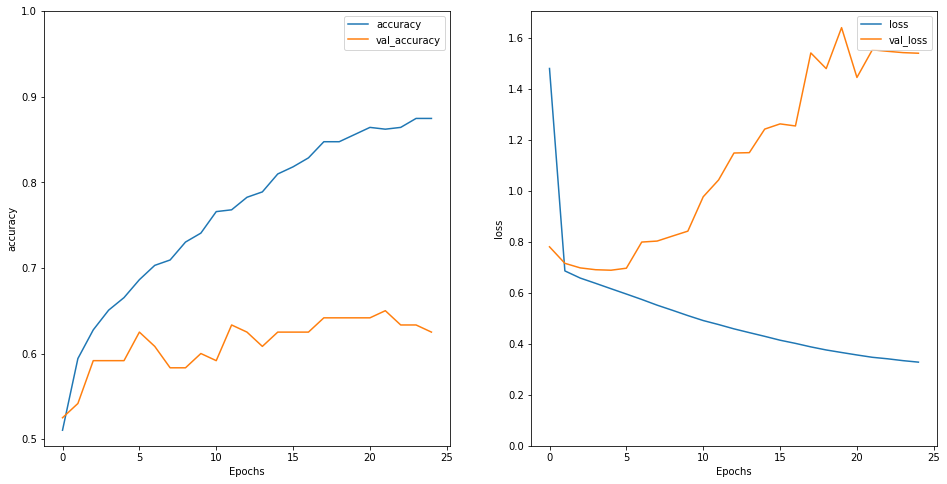

In [75]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

In [76]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_3 (TextVe (None, None)              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 16)          4000      
_________________________________________________________________
rnn_3 (RNN)                  (None, 1)                 18        
Total params: 4,018
Trainable params: 4,018
Non-trainable params: 0
_________________________________________________________________


# LSTM

In [77]:
encoder = layers.experimental.preprocessing.TextVectorization(
    max_tokens=HP.vocab_size
)
encoder.adapt(RAW_DATA.X_train.to_numpy())

In [78]:
model = Sequential()

# Encoder 
model.add(encoder)

# Embedding
model.add(
    layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = HP.embedding_dim,
        # Use msking to handle the variable sequence lengths
        mask_zero = True,
    )
)

# RNN
model.add(
    layers.RNN(
        layers.LSTMCell(
            HP.rnn_dim,
            activation = HP.rnn_activation,
        )
    )
)

# Dense output
# model.add(
#     layers.Dense(
#         HP.output_dim,
#         activation = HP.output_activation
#     )
# )

# model.add(
#     layers.Dense(1)
# )

model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [83]:
history = model.fit(
    RAW_DATA.X_train,
    RAW_DATA.y_train,
    epochs = 50,
    validation_split = 0.2,
)

Epoch 1/50
15/15 [==============================] - 2s 69ms/step - loss: 0.5602 - accuracy: 0.7197 - val_loss: 0.6670 - val_accuracy: 0.6500
Epoch 2/50
15/15 [==============================] - 2s 111ms/step - loss: 0.5522 - accuracy: 0.7197 - val_loss: 0.6697 - val_accuracy: 0.6500
Epoch 3/50
15/15 [==============================] - 2s 82ms/step - loss: 0.5445 - accuracy: 0.7301 - val_loss: 0.7640 - val_accuracy: 0.6417
Epoch 4/50
15/15 [==============================] - 2s 126ms/step - loss: 0.5371 - accuracy: 0.7406 - val_loss: 0.7627 - val_accuracy: 0.6417
Epoch 5/50
15/15 [==============================] - 2s 118ms/step - loss: 0.5296 - accuracy: 0.7448 - val_loss: 0.7633 - val_accuracy: 0.6417
Epoch 6/50
15/15 [==============================] - 2s 121ms/step - loss: 0.5220 - accuracy: 0.7469 - val_loss: 0.7638 - val_accuracy: 0.6333
Epoch 7/50
15/15 [==============================] - 2s 122ms/step - loss: 0.5147 - accuracy: 0.7490 - val_loss: 0.7679 - val_accuracy: 0.6250
Epoch 8/

In [84]:
test_loss, test_acc = model.evaluate(RAW_DATA.X_test, RAW_DATA.y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

5/5 [==============================] - 0s 36ms/step - loss: 1.5936 - accuracy: 0.6333
Test Loss: 1.5936352014541626
Test Accuracy: 0.6333333253860474


(0.0, 1.6993053048849105)

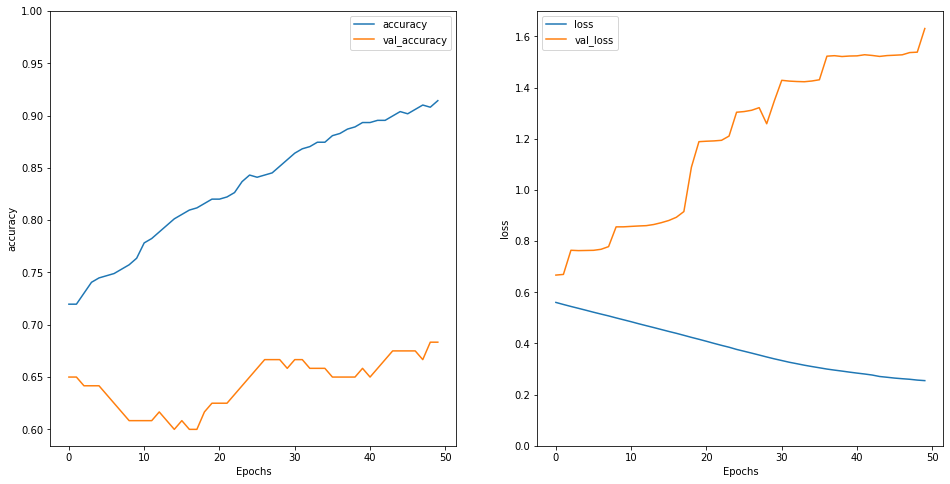

In [85]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

In [82]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_4 (TextVe (None, None)              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, None, 16)          4000      
_________________________________________________________________
rnn_4 (RNN)                  (None, 1)                 72        
Total params: 4,072
Trainable params: 4,072
Non-trainable params: 0
_________________________________________________________________
